in depth dive into imputation
- which imputation method (data average vs known domain average) works better?
- why does that method work better?
- what can we deduce from these results?

In [1]:
## import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import wandb
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
from scipy.stats import sem, norm

Data process

In [2]:
df = pd.read_csv("data/filtered_ds.csv")

In [3]:
df = df.sort_values(by=["patient_id", "start_time_min"])

In [4]:
def process_row(row):
    values_a = [float(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [5]:
def create_training_data(data : pd.DataFrame):
    score = np.zeros((1,14))
    scores = np.zeros((len(data), 14))
    i = 0
    
    data = data.sort_values(by=["start_time_min"])
    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)
        for j in range(len(domains)):
            score[0, int(domains[j] - 1)] = domain_scores[j]
        # set score to the score list average
        scores[i] = score
        i += 1
    
    scores_df = pd.DataFrame(scores, columns=["domain %d score" % i for i in range(1, 15)])
    data.reset_index(drop=True, inplace=True)
    scores_df.reset_index(drop=True, inplace=True)
    data = pd.concat([data, scores_df], axis=1)
    return data

In [6]:
data = df.groupby("patient_id")[df.columns].apply(create_training_data).reset_index(drop=True)

In [7]:
model_data = data[["patient_id"] + ["domain %d score" % i for i in range(1, 15)]]

In [8]:
def filter_nonzero_rows(df, max_zeros):
    # Count number of zeros in each row
    zeros_count = (df == 0).sum(axis=1)
    
    # Filter rows with at most max_zeros number of zeros
    non_zero_rows = df[zeros_count <= max_zeros]
    return non_zero_rows

In [9]:
model_data = filter_nonzero_rows(model_data.copy(deep=True), 0)

In [10]:
train_data, test_data = train_test_split(model_data, test_size=0.25)

In [11]:
model_data = model_data[["domain %d score" % i for i in range(1, 15)]]

In [12]:
# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the data
normalized_data = scaler.fit_transform(model_data)

In [13]:
train_data = train_data[["domain %d score" % i for i in range(1, 15)]]
test_data = test_data[["domain %d score" % i for i in range(1, 15)]]

In [14]:
def generate_random_array(rows, cols, N):
    if N > cols:
        raise ValueError("N cannot be greater than the number of columns.")
    
    # Create an array of ones with the desired shape
    array = np.ones((rows, cols), dtype=int)
    
    # Randomly assign N zeros to each row
    for i in range(rows):
        indices = np.random.choice(cols, N, replace=False)
        array[i, indices] = 0
    
    return array, array.shape[0] * N

In [15]:
def generate_mask(data, N=10):
    rows, cols = data.shape
    assert(cols == 14)
    mask, n_zeros = generate_random_array(rows, cols, N)
    return data * mask, n_zeros, mask

imputation methods

In [16]:
## data average
def impute_with_column_mean(data : pd.DataFrame):
    """
    Imputes missing values (represented as 0) in a DataFrame with the mean of the non-zero values in the same column.

    Parameters:
    - data (pd.DataFrame): The DataFrame to impute.

    Returns:
    - pd.DataFrame: The DataFrame with missing values imputed using column means.
    """
    # Replace '0' with NaN to handle them as missing values
    imputed_data = data.replace(0, np.nan)
    
    # Calculate the mean of each column, ignoring NaNs
    column_means = imputed_data.mean()
    # replace the nans with 0 since that means there's no data at all for that column
    column_means = column_means.replace(np.nan, 0)

    
    # Replace NaN values in each column with the mean of that column
    imputed_data.fillna(column_means, inplace=True)

    return imputed_data

In [17]:
## known domain average
def impute_with_row_average(data : pd.DataFrame):
    """
    Imputes missing values (NaN) in a DataFrame with the average of the non-missing values in the same row.

    Parameters:
    - data (pd.DataFrame): The DataFrame to impute.

    Returns:
    - pd.DataFrame: The DataFrame with missing values imputed.
    """
    # Create a copy of the DataFrame to avoid modifying the original data
    imputed_data = data.copy()
    # Replace '0' with NaN to handle them as missing values
    imputed_data = data.replace(0, np.nan)

    # Iterate over each row
    for index, row in imputed_data.iterrows():
        # Calculate the mean of the non-NaN values in the row
        mean_value = row.mean()
        if np.isnan(mean_value):
            mean_value = 0

        # Replace NaN values in the row with the calculated mean
        imputed_data.loc[index] = row.fillna(mean_value)

    return imputed_data

In [18]:
# mode = known => impute by average of other domains, mode = data => impute by average of the data set
def imputation(data, mode=""):
    data = pd.DataFrame(data)
    if mode == "known":
        return impute_with_row_average(data)
    elif mode == "data":
        return impute_with_column_mean(data)

Visualize

In [19]:
model_data = model_data.to_numpy()
# model_data = normalized_data

In [20]:
## full data version
data_all = data[["domain %d score" % i for i in range(1, 15)]].to_numpy()
imputation_known_domain = imputation(data_all, mode="known").to_numpy()
imputation_data_average = imputation(data_all, mode="data").to_numpy()
n_missing = np.count_nonzero(data_all==0)

np.sum(np.abs(imputation_known_domain - data_all    )) / n_missing, np.sum(np.abs(imputation_data_average - data_all)) / n_missing

(0.490681790802753, 0.5699732424170524)

In [21]:
def get_accuracy(pred, original, mask):
    pred = np.multiply(pred, mask)
    original = np.multiply(original, mask)
    n_missing = np.sum(mask)
    if n_missing == 0: n_missing = 1
    return np.sum(np.abs(pred - original)) / n_missing

In [22]:
## performance
x_values = range(14) # masked number of domains
# list of average error per missing value for each imputation methods
y_values_known = []
y_values_data = []

for masked_number in x_values:
    masked_data, n_missing, mask = generate_mask(model_data, N=masked_number)
    xor_mask = mask ^ 1
    assert(n_missing == np.sum(xor_mask)) # xor the mask to get the mask to flip bits, sum it up to find number of missing values
    imputation_known_domain = imputation(masked_data, mode="known").to_numpy()
    imputation_data_average = imputation(masked_data, mode="data").to_numpy()

    y_values_known.append(get_accuracy(imputation_known_domain, model_data, xor_mask))
    y_values_data.append(get_accuracy(imputation_data_average, model_data, xor_mask))

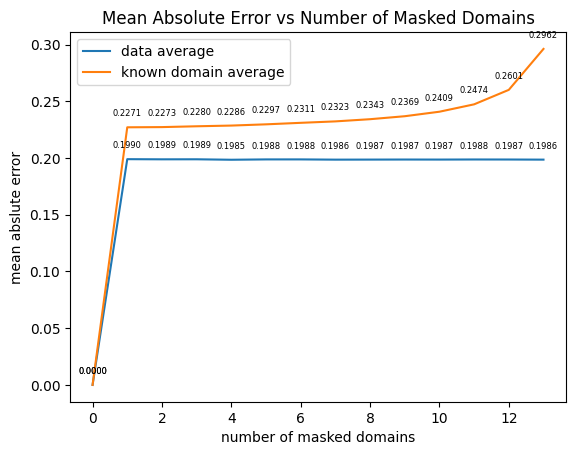

In [23]:
plt.figure()
plt.plot(x_values, y_values_data, label="data average")
plt.plot(x_values, y_values_known, label="known domain average")
plt.legend()
for x, y1, y2 in zip(x_values, y_values_known, y_values_data):
    offset = 8
    size=6

    label = "{:.4f}".format(y1)
    plt.annotate(label, # this is the text
                (x,y1), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,offset), # distance from text to points (x,y)
                ha='center',
                fontsize=size) # horizontal alignment can be left, right or center
    
    label = "{:.4f}".format(y2)
    plt.annotate(label, # this is the text
                (x,y2), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,offset), # distance from text to points (x,y)
                ha='center', 
                fontsize=size) # horizontal alignment can be left, right or center
    
    plt.xlabel("number of masked domains")
    plt.ylabel("mean abslute error")
    plt.title("Mean Absolute Error vs Number of Masked Domains")

## Which imputation method works better?
From what we have above, data average works better. This is confusing because we would expect that known domain average, using information from other domain, should perform better or at least on par (well, i guess it's not too far. And that raises a good question of how accuraㄔe do we expect the numbers to be?)

### What to do next?
- look at distribution of the scores for each domain. is it mostly around average (~0.2 away from average for most because that's the average error)?
- do some in-depth case studies. some things to look out for: why is the curve for data average so so so flat? there's practically no difference in values across. seems unlikely.

### some thoughts
- known domain average doesn't do as well maybe because the scores are not normalized. so for the same percentile, one domain can have a score of 0.2 and the other a 0.8, so it's more or less random if the information is even useful. ***using normalized data doesn't seem to make a big difference***

Distribution of scores

In [24]:
def plot_domain_dist(d : pd.DataFrame, domain_name):
    domain_scores = d[domain_name].replace(0, np.NaN)
    mean_value = domain_scores.mean()
    median_value = domain_scores.median()
    std_value = domain_scores.std()


    plt.figure()
    sns.histplot(data=d, x=domain_name, kde=True)
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value: .4f}')
    plt.axvline(median_value, color='green', linestyle= 'dashed', linewidth=2, label=f'Median: {median_value: .4f}')
    plt.axvline(mean_value + std_value, color="orange", linestyle="dashed", linewidth=2, label=f"SD1: {std_value: .4f}")
    plt.axvline(mean_value - std_value, color="orange", linestyle="dashed", linewidth=2)
    plt.axvline(mean_value + 2 * std_value, color="purple", linestyle="dashed", linewidth=2, label="SD2")
    plt.axvline(mean_value - 2* std_value, color="purple", linestyle="dashed", linewidth=2)
    plt.legend()

In [25]:
data_full = data.copy(deep=True)
data = filter_nonzero_rows(data[["domain %d score" % i for i in range(1, 15)]], 0)

In [26]:
data["domain 1 score"][abs(data["domain 1 score"] - data["domain 1 score"].mean()) <= 0.2].count() / data.shape[0]

0.62416348957989

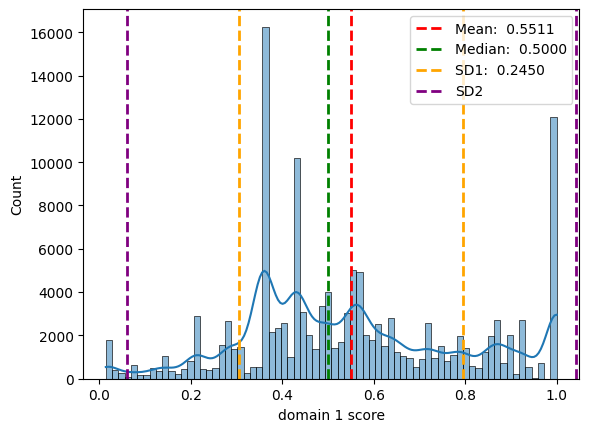

In [27]:
plot_domain_dist(data, "domain 1 score")

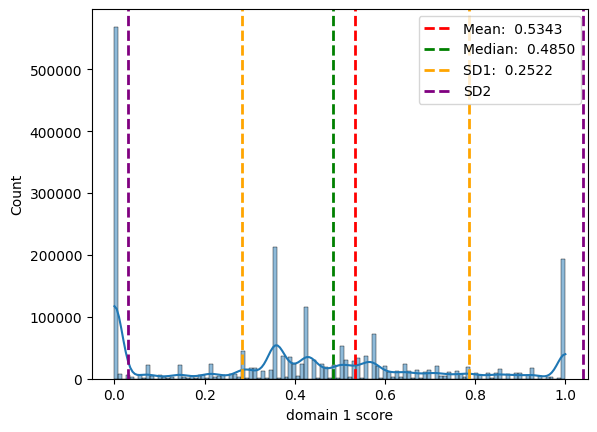

In [28]:
plot_domain_dist(data_full, "domain 1 score")

In [29]:
data["domain 2 score"][abs(data["domain 2 score"] - data["domain 2 score"].mean()) <= 0.2].count() / data.shape[0]

0.44635681806495214

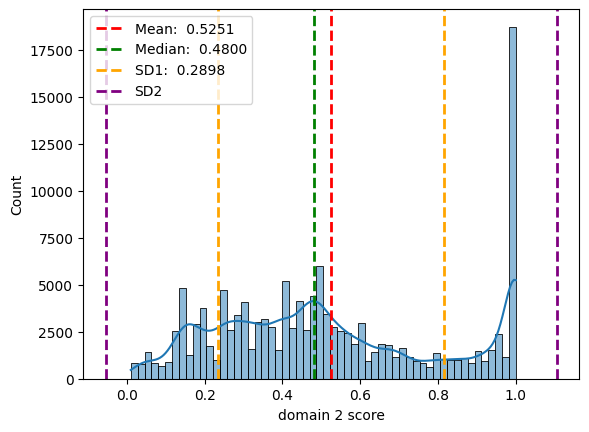

In [30]:
plot_domain_dist(data, "domain 2 score")

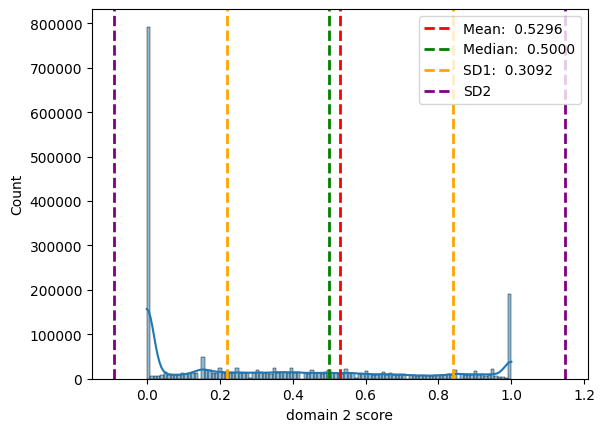

In [31]:
plot_domain_dist(data_full, "domain 2 score")

In [32]:
data["domain 3 score"][abs(data["domain 3 score"] - data["domain 3 score"].mean()) <= 0.2].count() / data.shape[0]

0.8518118576958958

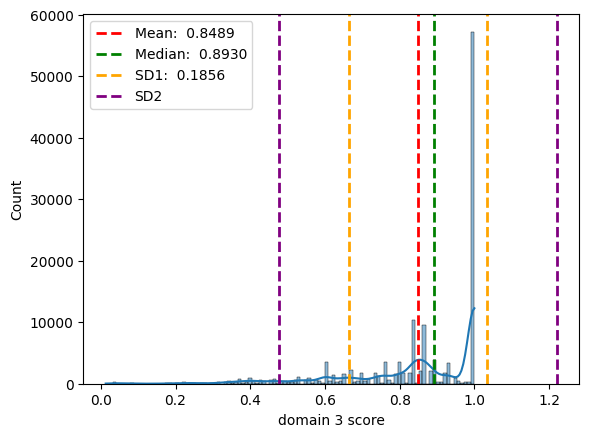

In [33]:
plot_domain_dist(data, "domain 3 score")

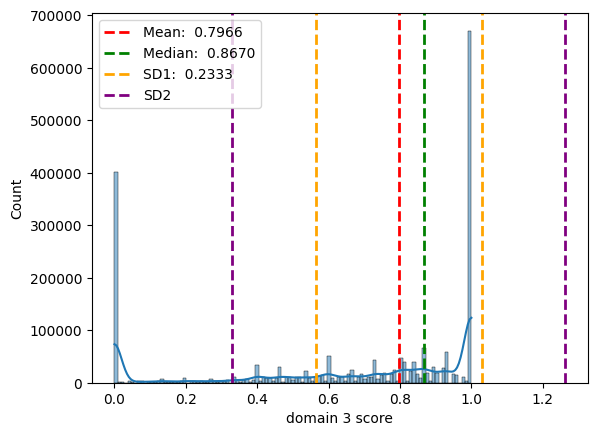

In [34]:
plot_domain_dist(data_full, "domain 3 score")

In [35]:
data["domain 4 score"][abs(data["domain 4 score"] - data["domain 4 score"].mean()) <= 0.2].count() / data.shape[0]

0.6160022331430755

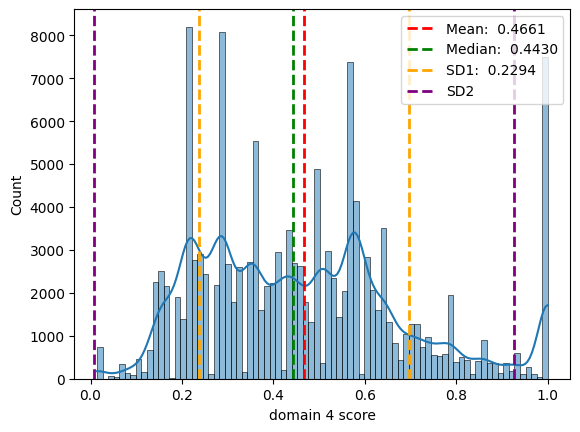

In [36]:
plot_domain_dist(data, "domain 4 score")

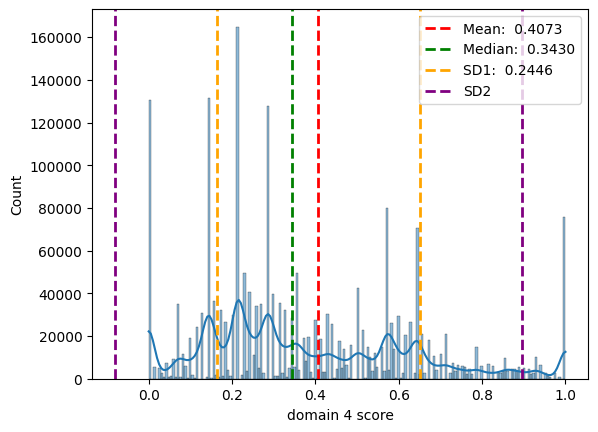

In [37]:
plot_domain_dist(data_full, "domain 4 score")

In [38]:
data["domain 5 score"][abs(data["domain 5 score"] - data["domain 5 score"].mean()) <= 0.2].count() / data.shape[0]

0.6508877478311332

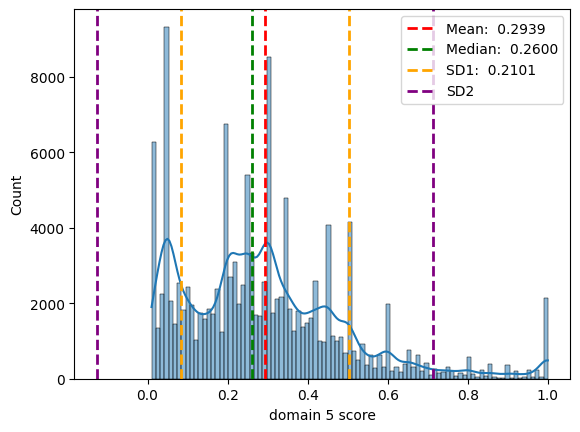

In [39]:
plot_domain_dist(data, "domain 5 score")

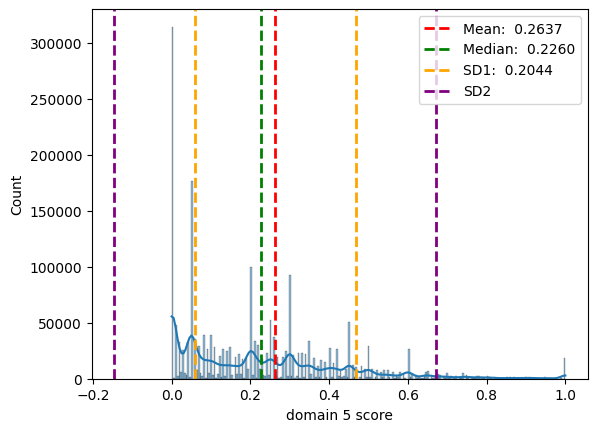

In [40]:
plot_domain_dist(data_full, "domain 5 score")

In [41]:
data["domain 6 score"][abs(data["domain 6 score"] - data["domain 6 score"].mean()) <= 0.2].count() / data.shape[0]

0.4575813003650895

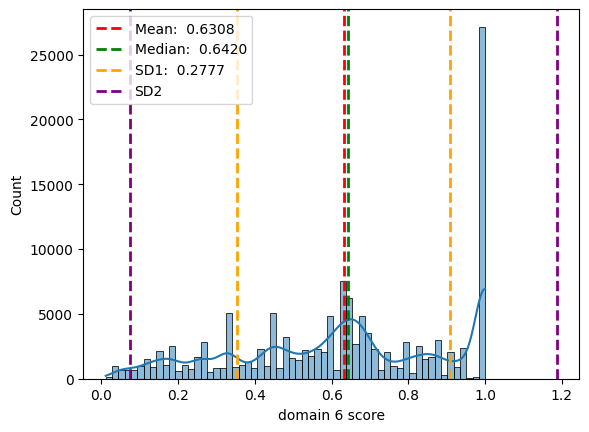

In [42]:
plot_domain_dist(data, "domain 6 score")

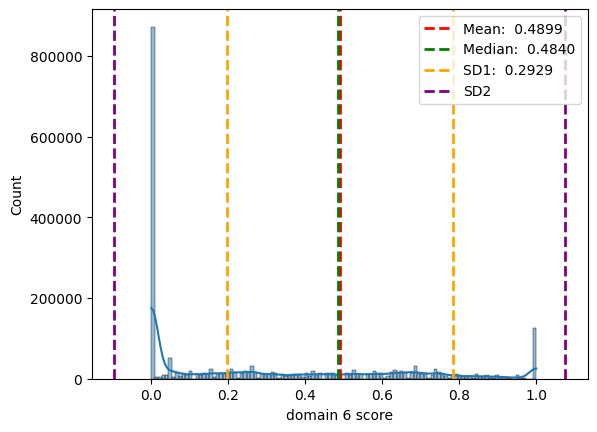

In [43]:
plot_domain_dist(data_full, "domain 6 score")

In [44]:
data["domain 7 score"][abs(data["domain 7 score"] - data["domain 7 score"].mean()) <= 0.2].count() / data.shape[0]

0.5166347121522651

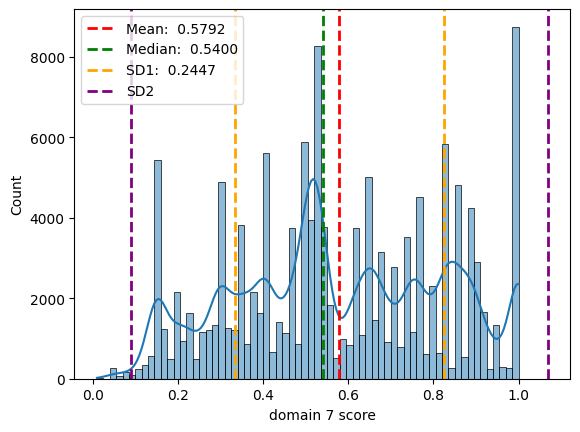

In [45]:
plot_domain_dist(data, "domain 7 score")

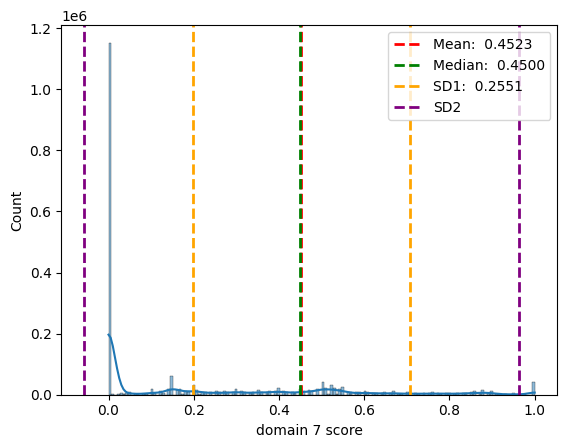

In [46]:
plot_domain_dist(data_full, "domain 7 score")

In [47]:
data["domain 8 score"][abs(data["domain 8 score"] - data["domain 8 score"].mean()) <= 0.2].count() / data.shape[0]

0.24375785089362453

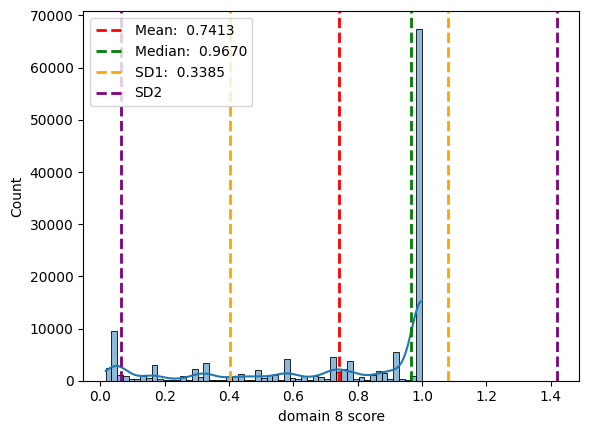

In [48]:
plot_domain_dist(data, "domain 8 score")

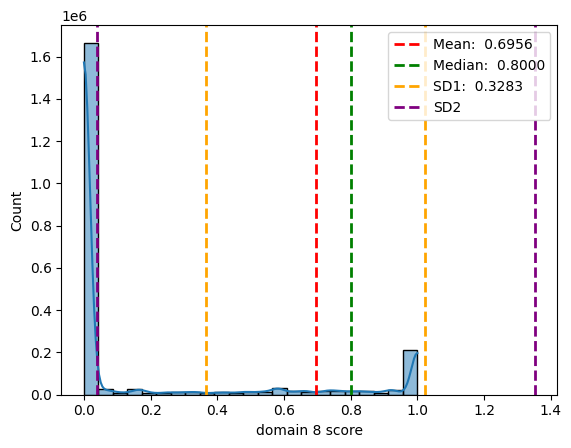

In [49]:
plot_domain_dist(data_full, "domain 8 score")

In [50]:
data["domain 9 score"][abs(data["domain 9 score"] - data["domain 9 score"].mean()) <= 0.2].count() / data.shape[0]

0.5460255195363289

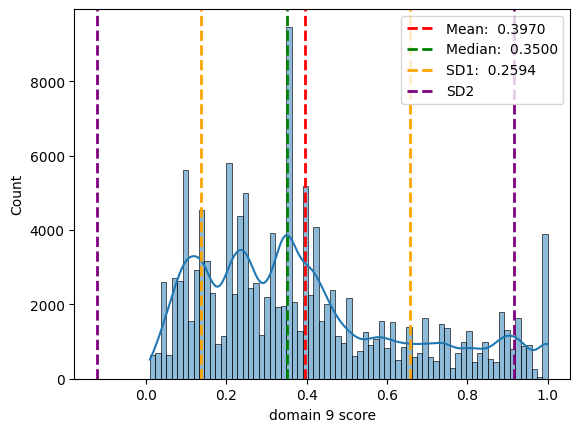

In [51]:
plot_domain_dist(data, "domain 9 score")

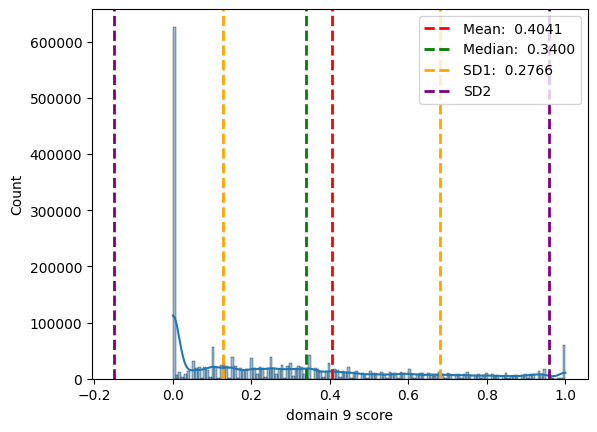

In [52]:
plot_domain_dist(data_full, "domain 9 score")

In [53]:
data["domain 10 score"][abs(data["domain 10 score"] - data["domain 10 score"].mean()) <= 0.2].count() / data.shape[0]

0.5746376651901477

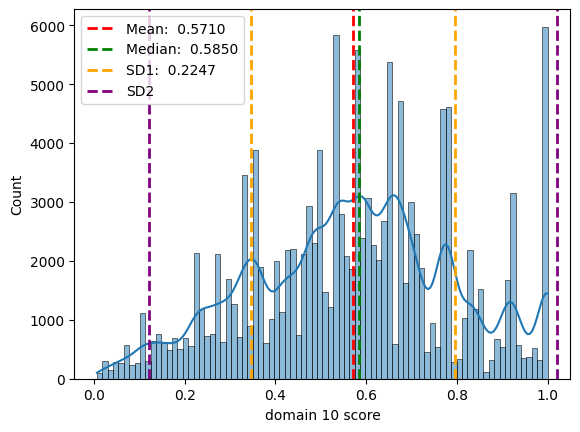

In [54]:
plot_domain_dist(data, "domain 10 score")

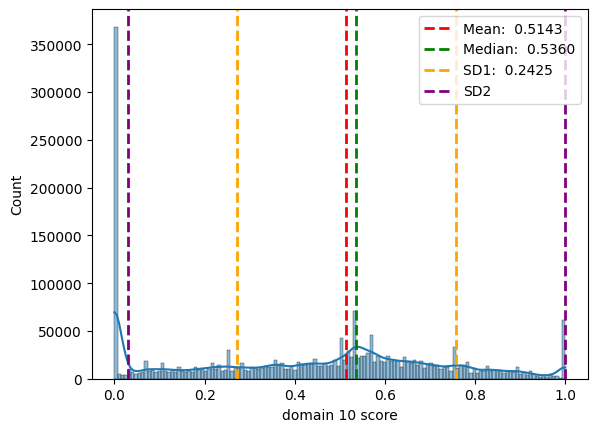

In [55]:
plot_domain_dist(data_full, "domain 10 score")

In [56]:
data["domain 11 score"][abs(data["domain 11 score"] - data["domain 11 score"].mean()) <= 0.2].count() / data.shape[0]

0.8311626301136406

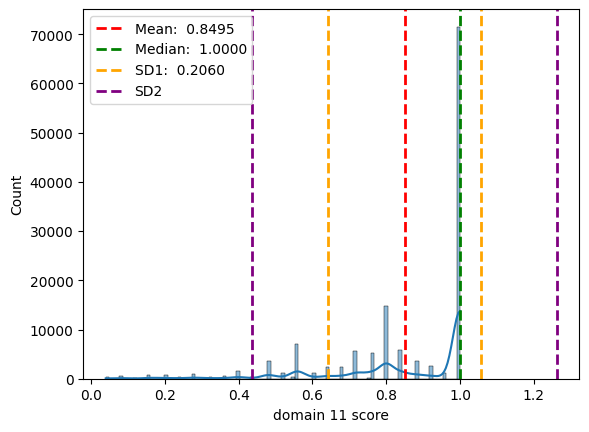

In [57]:
plot_domain_dist(data, "domain 11 score")

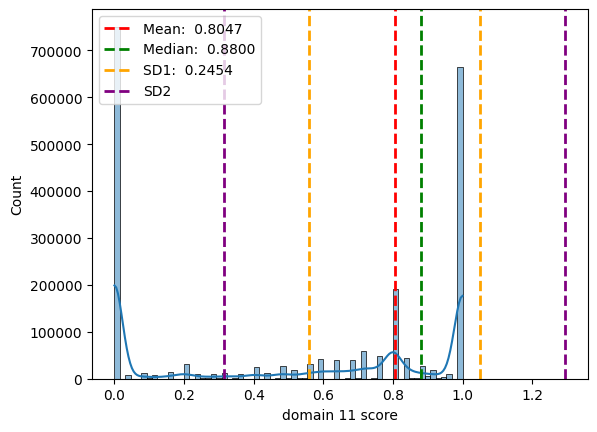

In [58]:
plot_domain_dist(data_full, "domain 11 score")

In [59]:
data["domain 12 score"][abs(data["domain 12 score"] - data["domain 12 score"].mean()) <= 0.2].count() / data.shape[0]

0.7041526176991281

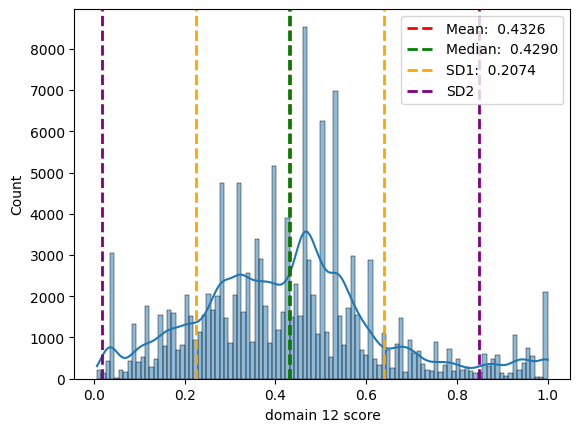

In [60]:
plot_domain_dist(data, "domain 12 score")

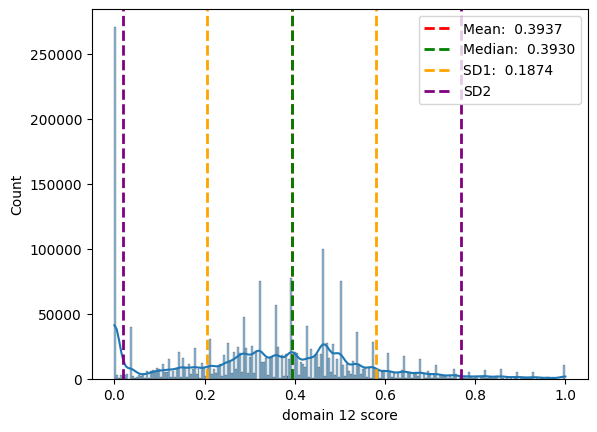

In [61]:
plot_domain_dist(data_full, "domain 12 score")

In [62]:
data["domain 13 score"][abs(data["domain 13 score"] - data["domain 13 score"].mean()) <= 0.2].count() / data.shape[0]

0.587918989796593

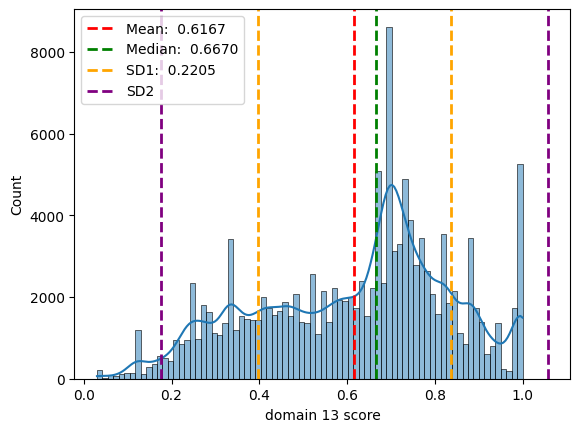

In [63]:
plot_domain_dist(data, "domain 13 score")

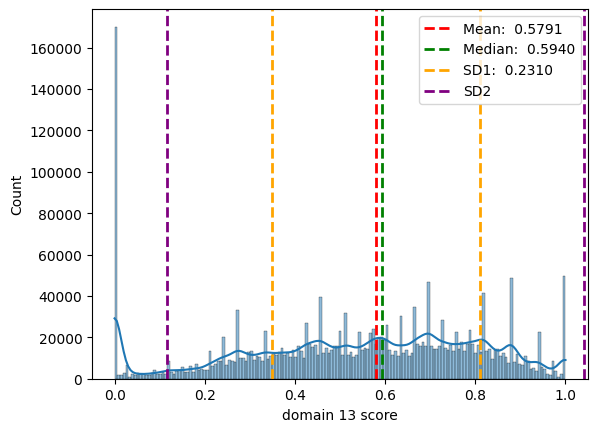

In [64]:
plot_domain_dist(data_full, "domain 13 score")

In [65]:
data["domain 14 score"][abs(data["domain 14 score"] - data["domain 14 score"].mean()) <= 0.2].count() / data.shape[0]

0.36796174273310267

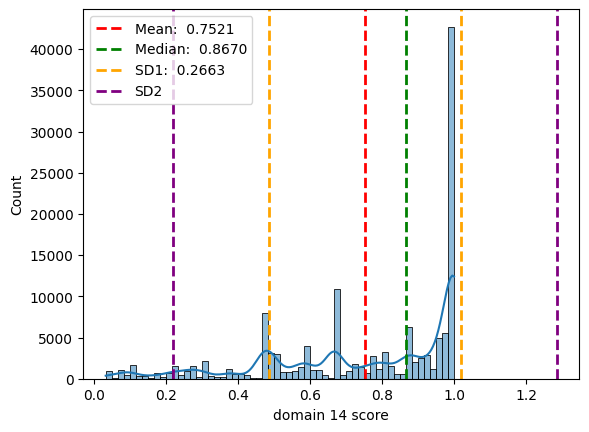

In [66]:
plot_domain_dist(data, "domain 14 score")

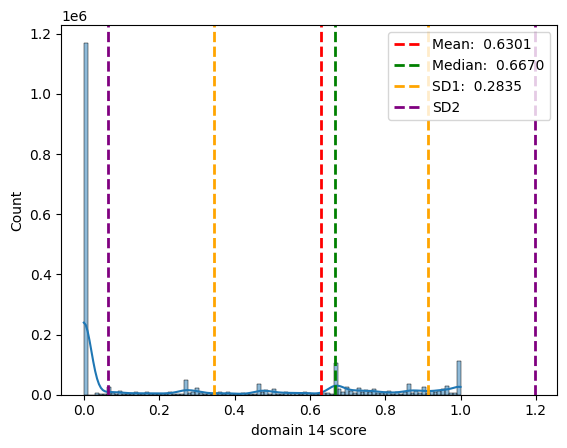

In [67]:
plot_domain_dist(data_full, "domain 14 score")

case study

In [68]:
## pick a random patient for case study
pid = random.choice(pd.unique(data_full["patient_id"]))
## save the patient's data
case_study_data = copy.deepcopy(data_full[data_full['patient_id'] == pid])

## reset index for the case study
case_study_data = case_study_data.reset_index(drop=True)

Bad pipe message: %s [b'\x82\xdf\xe33q\x04^\xfb$\x19\x99i\xda8\x82d\xcb*\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00']
Bad pipe message: %s [b"\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc0\x19\xc0#